In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
sns.set_theme(style="darkgrid")


t = 10
t_extended = 15
confidence_required = 0.95
chart_simulations = 100

In [2]:
def simulate_z_scores(days: int, simulations:int = 1_000_000) -> np.ndarray:

    np.random.seed(770)
    daily_z_scores = np.random.normal(size=(simulations, days+1))
    daily_z_scores[:, 0] = 0
    rolling_scores = np.cumsum(daily_z_scores, axis=1)
    day_range = np.arange(0, days+1)
    scalars = np.divide(1, day_range, where=day_range!=0)
    scalars[0] = 0
    scalars = scalars ** 0.5

    return rolling_scores * scalars

def get_z_score(probability: float, is_two_sided_test: bool) -> float:
    if is_two_sided_test:
        upper_probability = 1-(1-probability)/2
        return norm.ppf(upper_probability)
    
    return norm.ppf(probability)

## Early Stopping Simulation

Simulate the effect on false positive rates if we allow our experiments to stop early.
One million simulations across 10 days for a two-sided hypothesis test with 95% confidence.

A preview of simulated z-scores is shown below.

In [3]:
day_range = np.arange(0, t + 1)
z_scores = simulate_z_scores(t)
df = pd.DataFrame(data=z_scores[:chart_simulations,:], columns=day_range)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.544612,-0.422714,0.195474,-0.467236,-0.434954,-1.682221,-1.268939,-1.256250,-1.341507,-1.576464
1,0.0,0.026402,-0.222106,0.509322,0.587724,0.391599,0.009202,0.221754,0.909173,1.071719,1.262328
2,0.0,1.233844,1.081976,0.293637,0.263471,-0.215188,-0.854861,-0.418853,-1.031895,-1.323522,-1.381453
3,0.0,0.540759,1.485691,1.664037,1.104691,0.480752,0.842859,0.490624,0.412685,0.296164,0.500044
4,0.0,-1.158948,-0.548486,0.237513,-0.195352,-0.563504,-0.128970,0.431022,0.213990,0.304144,0.045042


## Early Stopping Visualisation
A visual comparison of false positives when comparing an experiment with early stopping versus one that runs to a close.

Only the first 100 trials are shown here (which obviously has a lot more sampling error) to keep the charts sane and consistent with [Defazio's](https://www.aarondefazio.com/tangentially/?p=83) analysis.

,Full Length,Early Stopping
0,5,17


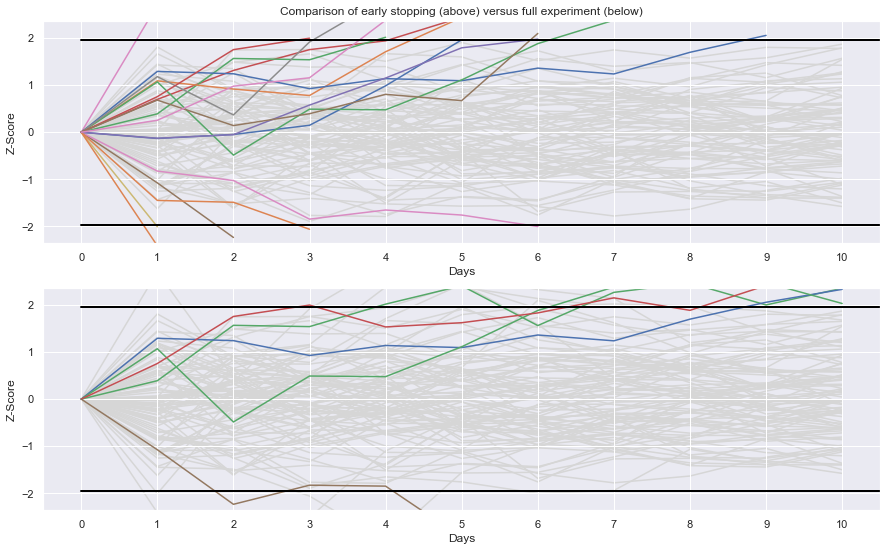

In [4]:
fig, (ax1, ax2) = plt.subplots(2)   
ax1.set_title('Comparison of early stopping (above) versus full experiment (below)')

z_required = get_z_score(confidence_required, True)
chart_lims = z_required + 0.4

df_early = df.copy()
for i in range(chart_simulations):
    row_scores = z_scores[i, :]
    if any([z > z_required for z in row_scores]):
        index = np.argmax(row_scores > z_required) + 1
        df_early.iloc[i, index:] = float('nan')
    if any([z < -z_required for z in row_scores]):
        index = np.argmax(row_scores < -z_required) + 1
        df_early.iloc[i, index:] = float('nan')

def plot_chart(df: pd.DataFrame, ax, figsize) -> None:
    df.T.plot.line(legend=False, figsize=figsize, ax=ax)
    line_hi  = plt.Line2D([0, 1_000], [z_required, z_required], linewidth=2, color='black')
    line_low = plt.Line2D([0, 1_000], [-z_required, -z_required], linewidth=2, color='black')
    ax.set_xticks(day_range)
    ax.set_xlabel('Days')
    ax.set_ylabel('Z-Score')
    ax.set_ylim(bottom=-chart_lims, top=chart_lims)
    ax.add_line(line_hi)
    ax.add_line(line_low)


plot_chart(df_early, ax1, (15,9))
for i in range(chart_simulations):
    row_scores = z_scores[i, :]
    if all([np.abs(z) < z_required for z in row_scores]):
        ax1.get_lines()[i].set_color("#d6d6d6")
        ax1.get_lines()[i].set_zorder(0)

plot_chart(df, ax2, (15,9))
for i in range(chart_simulations):
    row_scores = z_scores[i, :]
    if np.abs(z_scores[i, -1]) < z_required:
        ax2.get_lines()[i].set_color("#d6d6d6")
        ax2.get_lines()[i].set_zorder(0)

early = np.sum(np.any(np.abs(df.values) > z_required, axis=1))
full = np.sum(np.abs(df.values[:, -1]) > z_required)
results = pd.DataFrame(data=[[full, early]], columns=['Full Length', 'Early Stopping'])
results

## Full simulation analysis
Analysis of false positive rates under a million simulations.

In [5]:
early = np.sum(np.any(np.abs(z_scores) > z_required, axis=1))
full = np.sum(np.abs(z_scores[:, -1]) > z_required) 
results = pd.DataFrame(data=[[full, early], [full / z_scores.shape[0], early / z_scores.shape[0]]], columns=['Full Length', 'Early Stopping'])
results

,Full Length,Early Stopping
0,49986.000000,193525.000000
1,0.049986,0.193525


## The follies of extending your A/B tests

,Sims,False positives,False Positive Rate
0,12162,2275,19%
1,35865,3174,9%
2,47712,13,0%


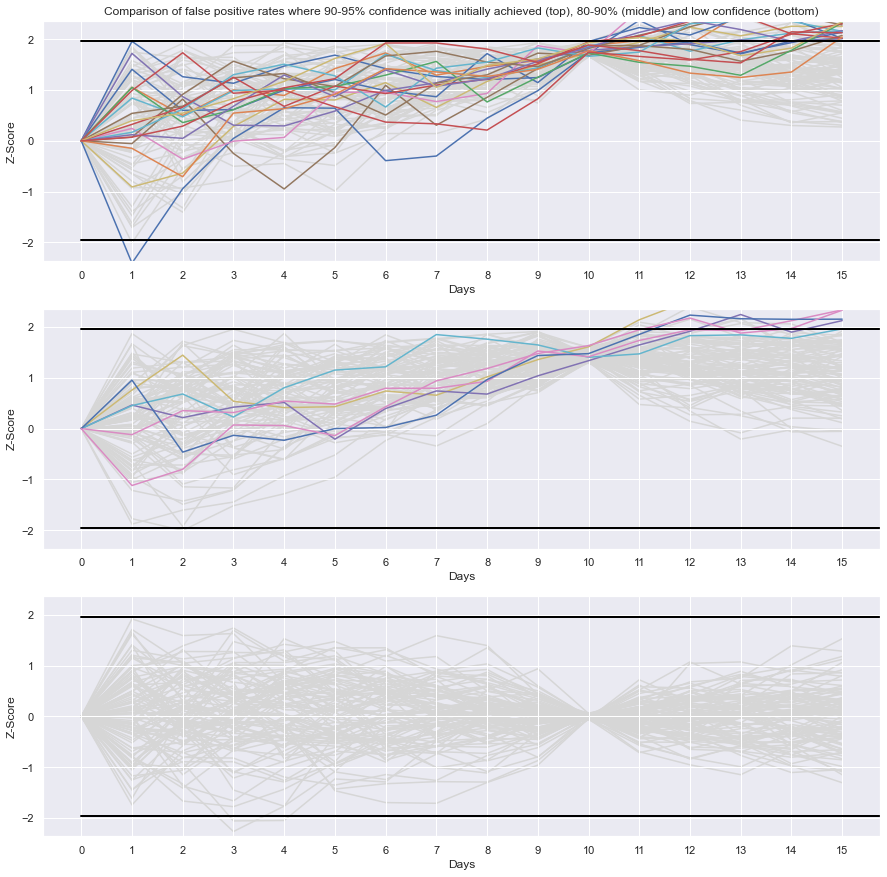

In [6]:
day_range = np.arange(0, t_extended+1)
z_scores = simulate_z_scores(t_extended)

z_score_95 = get_z_score(0.95, True)
z_score_90 = get_z_score(0.90, True)
z_score_80 = get_z_score(0.80, True)
z_score_5p = get_z_score(0.05, True)
z_score_5n = -z_score_5p

limits = [
    (z_score_90, z_score_95),
    (z_score_80, z_score_90),
    (z_score_5n, z_score_5p)
]

num_charts = len(limits)

def get_relevant_simulations(
    z_scores: np.ndarray,
    days: int,
    z_low: float,
    z_high: float,
    z_significant: float) -> np.ndarray:
    
    # Note for comment 1 below:
    # The chart includes an additional criteria: (max_z_score < z_significant)
    # Visually, this is a bit less noisey but it is more accurate to remove this as it introduces a small bias.
    # It exists to avoid any confusion re. early stopping.
    max_z_score = np.max(z_scores[:, :days+1], axis=1)
    final_scores = z_scores[:, days]
    insig_but_close = (final_scores > z_low) & (final_scores < z_high) & (max_z_score < z_significant) # comment 1
    return z_scores[insig_but_close, :]

fig, axes = plt.subplots(num_charts)  
axes[0].set_title('Comparison of false positive rates where 90-95% confidence was initially achieved (top), 80-90% (middle) and low confidence (bottom)')

stats = []

for i in range(num_charts):
    
    z_low, z_high = limits[i]
    near_significance = get_relevant_simulations(z_scores, t, z_low, z_high, z_required)
    num_sims = near_significance.shape[0] 
    false_positives = np.sum(near_significance[:, -1] > z_required)
    fp_rate = false_positives / num_sims
    result = (num_sims, false_positives, fp_rate)
    stats.append(result)
    
    ax = axes[i]
    extended_day_range = np.arange(0, t_extended+1)
    df_extended = pd.DataFrame(data=near_significance[:chart_simulations,:], columns=extended_day_range)

    plot_chart(df_extended, ax, (15,15))
    for i in range(chart_simulations):
        if  near_significance[i, -1] < z_required:
            ax.get_lines()[i].set_color("#d6d6d6")
            ax.get_lines()[i].set_zorder(0)
            
df_results = pd.DataFrame(data=stats, columns=['Sims', 'False positives', 'False Positive Rate'])
df_results.style.format({"False Positive Rate":"{:.0%}"})